In [1]:
# default_exp pytorch_quantization_conversion

This notebook involves converting a pytorch model into pytorch's quantization model. You need to explicitly fuse some operations (like tensorrt does). Quantization aware training is also an interesting choice I'd like to investigate. Lastly, as of 1.7.0, INT8 quantization is only supported on the CPU. 

Really, I'd like to see if it's faster to run inference on the CPU with AVX2 instructions when you take into account xferring data to GPU, and xferring it back.

In [2]:
#export
import torch
from torch import nn
from torch.quantization import QuantStub, DeQuantStub

In [3]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Create model

Note that instance norm is not supported. I'd like to avoid batch norm since it doesn't work well for small batch sizes; I'm gonna try just training without any normalization layers and see how that goes. Also transposed convolutions are not supported yet, so replace with an Upsampling operation.

In [5]:
#export
def get_out_channels(m):
    # Gets out_channels of last conv layer
    out_channels = None
    for m_sub in m.modules():
        if isinstance(m_sub, nn.modules.conv._ConvNd):
            out_channels = m_sub.out_channels
    return out_channels

In [6]:
#export
def conv_layer(in_channels, out_channels, kernel_size, stride, padding):
    return nn.intrinsic.ConvReLU2d(
        nn.Conv2d(in_channels, 
                  out_channels, 
                  kernel_size=kernel_size, 
                  stride=stride, 
                  padding=padding),
        nn.ReLU(inplace=True)
    )

In [7]:
#export
def up_conv_layer(in_channels, out_channels, kernel_size, stride, padding, scale_factor):
    return nn.Sequential(
        conv_layer(in_channels, out_channels, kernel_size, stride, padding),
        nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
    )

In [8]:
#export
def get_encoder(in_channels, layout_encoder):
    prev_out_channels = in_channels
    encoder = []
    for layout_layer in layout_encoder:
        layer = []
        for layout_conv in layout_layer:
            layer.append(conv_layer(prev_out_channels, *layout_conv))
            prev_out_channels = layout_conv[0]
        encoder.append(nn.Sequential(*layer))
    return nn.Sequential(*encoder)

In [9]:
#export
class UNET_QAT(nn.Module):
    def __init__(self, encoder, out_channels):
        super(UNET_QAT, self).__init__()
        self.encoder = encoder
        self.decoder = self._get_decoder(encoder)
        self.last_conv = nn.Conv2d(get_out_channels(self.decoder), 
                                   out_channels, 
                                   kernel_size=3, 
                                   stride=1, 
                                   padding=1)
        self.quant   = QuantStub()
        self.dequant = DeQuantStub()
        
    def _get_decoder(self, encoder):
        # Assumes each level of encoder shrinks by a factor of 2
        decoder = []
        for i in reversed(range(len(encoder))):
            in_channels = get_out_channels(encoder[i])
            if len(decoder) > 0: 
                in_channels += get_out_channels(decoder[-1])
            decoder.append(up_conv_layer(in_channels,
                                         get_out_channels(encoder[i])//2,
                                         kernel_size=3,
                                         stride=1,
                                         padding=1,
                                         scale_factor=2))
        return nn.Sequential(*decoder)

    def forward(self, X):
        X = self.quant(X)
        
        Xs = [X]
        for conv_down in self.encoder:
            Xs.append(conv_down(Xs[-1]))
        X = Xs[-1][:,0:0,:,:] # Empty, but same size and dimension as last X
        for idx, conv_up in enumerate(self.decoder):
            X = conv_up(torch.cat([X, Xs[-(idx+1)]], dim=1))
        X = self.last_conv(X)
        
        X = self.dequant(X)
        return X

In [10]:
in_channels  = 1
out_channels = 5
layout_encoder = [[[32,5,2,2]],
                  [[32,3,1,1],[32,3,2,1]],
                  [[64,3,1,1],[64,3,2,1]],
                  [[128,3,1,1],[128,3,2,1]]]
model = UNET_QAT(get_encoder(in_channels, layout_encoder), out_channels)
model = model.eval()

check model

In [11]:
model

UNET_QAT(
  (encoder): Sequential(
    (0): Sequential(
      (0): ConvReLU2d(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): ReLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): ConvReLU2d(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): ConvReLU2d(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (2): Sequential(
      (0): ConvReLU2d(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (3): Sequential(
      (0): ConvReLU2d(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (1): 

In [12]:
torch.set_grad_enabled(False) 

In [13]:
X = np.fromfile('batches/X0.raw', dtype=np.float32).reshape(1, 1, 384, 512)
X = torch.from_numpy(X)

In [14]:
with torch.autograd.profiler.profile() as prof:
    y = model(X)
print(prof.key_averages().table(sort_by="self_cpu_time_total"))

-----------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name                           Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     Number of Calls  
-----------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
aten::mkldnn_convolution       76.49%           28.151ms         76.75%           28.247ms         2.354ms          12               
aten::upsample_bilinear2d      14.80%           5.448ms          14.88%           5.477ms          1.369ms          4                
aten::_cat                     3.95%            1.452ms          4.08%            1.503ms          375.650us        4                
aten::threshold_               3.12%            1.148ms          3.12%            1.148ms          104.390us        11               
aten::_convolution             0.50%            183.214us    

In [15]:
%%timeit
y = model(X)

28 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
y[0,0,0,0].item()

0.05070667713880539

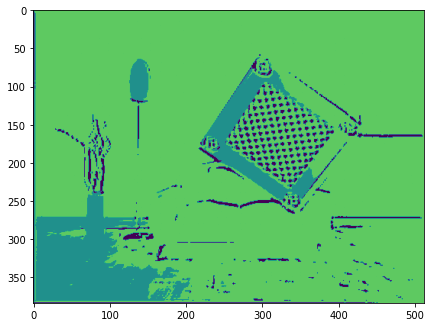

In [17]:
plt.figure(figsize=(7, 7))
plt.imshow(y.argmax(dim=1)[0].cpu().numpy(), vmin=0, vmax=4)

# Try post training static quantization

`fbgemm` is used for x86

In [18]:
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.backends.quantized.engine='fbgemm'

In [19]:
torch.quantization.prepare(model, inplace=True)

/home/justin/miniconda3/envs/tensorrt/lib/python3.7/site-packages/torch/quantization/observer.py:120: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


UNET_QAT(
  (encoder): Sequential(
    (0): Sequential(
      (0): ConvReLU2d(
        (0): Conv2d(
          1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)
          (activation_post_process): HistogramObserver()
        )
        (1): ReLU(
          inplace=True
          (activation_post_process): HistogramObserver()
        )
      )
    )
    (1): Sequential(
      (0): ConvReLU2d(
        (0): Conv2d(
          32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
          (activation_post_process): HistogramObserver()
        )
        (1): ReLU(
          inplace=True
          (activation_post_process): HistogramObserver()
        )
      )
      (1): ConvReLU2d(
        (0): Conv2d(
          32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
          (activation_post_process): HistogramObserver()
        )
        (1): ReLU(
          inplace=True
          (activation_post_process): HistogramObserver()
        )
      )
    )
    (2): Sequential(
   

Must calibrate

In [20]:
for file_batch in Path('batches').glob('*.raw'):
    X = np.fromfile(file_batch, dtype=np.float32).reshape(1, 1, 384, 512)
    X = torch.from_numpy(X)
    y = model(X)

In [21]:
torch.quantization.convert(model, inplace=True)

UNET_QAT(
  (encoder): Sequential(
    (0): Sequential(
      (0): QuantizedConvReLU2d(1, 32, kernel_size=(5, 5), stride=(2, 2), scale=0.013090508058667183, zero_point=0, padding=(2, 2))
    )
    (1): Sequential(
      (0): QuantizedConvReLU2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.006067873444408178, zero_point=0, padding=(1, 1))
      (1): QuantizedConvReLU2d(32, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.002087924163788557, zero_point=0, padding=(1, 1))
    )
    (2): Sequential(
      (0): QuantizedConvReLU2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.0009947983780875802, zero_point=0, padding=(1, 1))
      (1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.0006304592243395746, zero_point=0, padding=(1, 1))
    )
    (3): Sequential(
      (0): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.0004800032766070217, zero_point=0, padding=(1, 1))
      (1): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=

In [22]:
X = np.fromfile('batches/X0.raw', dtype=np.float32).reshape(1, 1, 384, 512)
X = torch.from_numpy(X)

In [23]:
with torch.autograd.profiler.profile() as prof:
    y = model(X)
print(prof.key_averages().table(sort_by="self_cpu_time_total"))

---------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name                               Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     Number of Calls  
---------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
aten::upsample_bilinear2d          65.12%           270.387ms        89.82%           372.934ms        93.234ms         4                
aten::q_zero_point                 24.70%           102.551ms        24.70%           102.551ms        0.196us          522267           
quantized::conv2d_relu             6.11%            25.381ms         6.18%            25.673ms         2.334ms          11               
quantized::conv2d                  2.24%            9.305ms          2.25%            9.329ms          9.329ms          1                
aten::_cat                       

In [24]:
%%timeit
y = model(X)

62.7 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
y[0,0,0,0].item()

0.04995867237448692

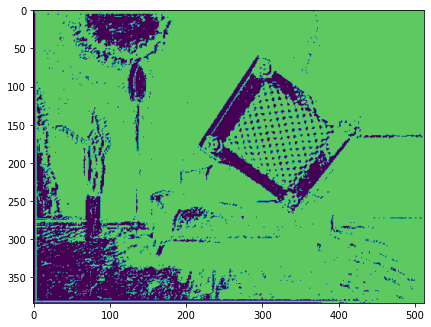

In [26]:
plt.figure(figsize=(7, 7))
plt.imshow(y.argmax(dim=1)[0].cpu().numpy(), vmin=0, vmax=4)

Slower results and incorrect inference... Does not look promising...